# Imports

In [1]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import cv2

import json

# Load the data

In [2]:
# read the data
data = pd.read_json('Indian_Number_plates.json',lines=True)
pd.set_option('display.max_colwidth', -1)
# delete the extras column
del data['extras']
# check the data dataframe
data.head()

content  \
0  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg                    
1  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg                                           
2  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg                                                        
3  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/52b45060-9645-47c7-882d-b69a5bf07eff___1006372d1351343820-my-new-maruti-swift-zxi-21102012241.jpg.jpeg   
4  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d1368191518-custom-number-plates-embossedplates1.jpg.jpeg   

                                                                                                                                                                                             annotation  
0  [{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.722084367245657, 'y': 0.5879828326180251}, {'x': 0.8684863523573201, 'y': 0.688841201716738}], 'imageWidth': 806, 'imageHeight': 466}]   
1  [{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.16194331983805602, 'y': 0.850779510022271}, {'x': 0.582995951417004, 'y': 1}], 'imageWidth': 494, 'imageHeight': 449}]                   
2  [{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.082, 'y': 0.697452229299363}, {'x': 0.23, 'y': 0.8280254777070061}], 'imageWidth': 500, 'imageHeight': 314}]                             
3  [{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.434, 'y': 0.667377398720682}, {'x': 0.718, 'y': 0.7654584221748401}], 'imageWidth': 500, 'imageHeight': 469}]                            
4  [{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.20879120879120802, 'y': 0.39076376554174}, {'x': 0.865134865134865, 'y': 0.9840142095914741}], 'imageWidth': 1001, 'imageHeight': 563}]

In [3]:
# Extract the points of the bounding boxes because thats what we want
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

data['height'] = data.apply(lambda row: row['annotation'][0]['imageHeight'], axis=1)
data['width'] = data.apply(lambda row: row['annotation'][0]['imageWidth'], axis=1)
# And drop the rest of the annotation info
del data['annotation']

data.head()

content  \
0  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg                    
1  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg                                           
2  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg                                                        
3  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/52b45060-9645-47c7-882d-b69a5bf07eff___1006372d1351343820-my-new-maruti-swift-zxi-21102012241.jpg.jpeg   
4  http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d1368191518-custom-number-plates-embossedplates1.jpg.jpeg   

                                                                                                   points  \
0  [{'x': 0.722084367245657, 'y': 0.5879828326180251}, {'x': 0.8684863523573201, 'y': 0.688841201716738}]   
1  [{'x': 0.16194331983805602, 'y': 0.850779510022271}, {'x': 0.582995951417004, 'y': 1}]                   
2  [{'x': 0.082, 'y': 0.697452229299363}, {'x': 0.23, 'y': 0.8280254777070061}]                             
3  [{'x': 0.434, 'y': 0.667377398720682}, {'x': 0.718, 'y': 0.7654584221748401}]                            
4  [{'x': 0.20879120879120802, 'y': 0.39076376554174}, {'x': 0.865134865134865, 'y': 0.9840142095914741}]   

   height  width  
0  466     806    
1  449     494    
2  314     500    
3  469     500    
4  563     1001

In [4]:
Images = []
Plates = []
Points = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))  # This is a numpy 3D array 
        
        # We append the image to the training input array
        Images.append(im)

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]
        Points.append([int(x_point_top), int(y_point_top),int(x_point_bot), int(y_point_bot)])
        
        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))
downloadTraining(data)

KeyboardInterrupt: 

In [6]:
len(Points)

237

# To check the x_min,y_min,x_max,y_max

In [7]:
# This gives the format of the annotations
Points[:10]

[[581, 273, 700, 320],
 [79, 381, 288, 449],
 [41, 219, 115, 259],
 [217, 312, 359, 359],
 [208, 219, 865, 553],
 [105, 279, 260, 335],
 [226, 240, 443, 314],
 [266, 247, 396, 320],
 [644, 507, 892, 578],
 [674, 364, 957, 572]]

# Dataframe construction

In [12]:
main_df = pd.DataFrame([row for row in Points], columns=['xmin', 'ymin', 'xmax', 'ymax'])
main_df.head()

xmin  ymin  xmax  ymax
0  581   273   700   320 
1  79    381   288   449 
2  41    219   115   259 
3  217   312   359   359 
4  208   219   865   553

# The great (not really) filename generation hack

In [16]:
images_path = 'Data-Images/Cars/'
give_me_236 = [images_path + str(i) + '.jpg' for i in list(range(0, 237))]
give_me_236[:10]


['Data-Images/Cars/0.jpg',
 'Data-Images/Cars/1.jpg',
 'Data-Images/Cars/2.jpg',
 'Data-Images/Cars/3.jpg',
 'Data-Images/Cars/4.jpg',
 'Data-Images/Cars/5.jpg',
 'Data-Images/Cars/6.jpg',
 'Data-Images/Cars/7.jpg',
 'Data-Images/Cars/8.jpg',
 'Data-Images/Cars/9.jpg']

In [17]:
main_df['filename'] = give_me_236
main_df.head(10)

xmin  ymin  xmax  ymax                filename
0  581   273   700   320   Data-Images/Cars/0.jpg
1  79    381   288   449   Data-Images/Cars/1.jpg
2  41    219   115   259   Data-Images/Cars/2.jpg
3  217   312   359   359   Data-Images/Cars/3.jpg
4  208   219   865   553   Data-Images/Cars/4.jpg
5  105   279   260   335   Data-Images/Cars/5.jpg
6  226   240   443   314   Data-Images/Cars/6.jpg
7  266   247   396   320   Data-Images/Cars/7.jpg
8  644   507   892   578   Data-Images/Cars/8.jpg
9  674   364   957   572   Data-Images/Cars/9.jpg

In [18]:
main_df['width'] = main_df['xmax'] - main_df['xmin']
main_df['height'] = main_df['ymax'] - main_df['ymin']

main_df.head()

xmin  ymin  xmax  ymax                filename  width  height
0  581   273   700   320   Data-Images/Cars/0.jpg  119    47    
1  79    381   288   449   Data-Images/Cars/1.jpg  209    68    
2  41    219   115   259   Data-Images/Cars/2.jpg  74     40    
3  217   312   359   359   Data-Images/Cars/3.jpg  142    47    
4  208   219   865   553   Data-Images/Cars/4.jpg  657    334

In [21]:
modified_df = pd.DataFrame()
modified_df['filename'] = main_df['filename']
modified_df['width'] = main_df['width']
modified_df['height'] = main_df['height']
modified_df['class'] = 'license_plate'
modified_df['xmin'] = main_df['xmin']
modified_df['ymin'] = main_df['ymin']
modified_df['xmax'] = main_df['xmax']
modified_df['ymax'] = main_df['ymax']

modified_df.head()

filename  width  height          class  xmin  ymin  xmax  ymax
0  Data-Images/Cars/0.jpg  119    47      license_plate  581   273   700   320 
1  Data-Images/Cars/1.jpg  209    68      license_plate  79    381   288   449 
2  Data-Images/Cars/2.jpg  74     40      license_plate  41    219   115   259 
3  Data-Images/Cars/3.jpg  142    47      license_plate  217   312   359   359 
4  Data-Images/Cars/4.jpg  657    334     license_plate  208   219   865   553

In [0]:
# 95% for train
train_labels = modified_df.sample(frac=0.95)
modified_df.drop(train_labels.index, axis=0, inplace=True)

# 5% for test
test_labels = modified_df

In [24]:
train_labels.head()

filename  width  height  ... ymin  xmax  ymax
105  Data-Images/Cars/105.jpg  684    293     ...  106  696   399 
38   Data-Images/Cars/38.jpg   118    39      ...  485  912   524 
136  Data-Images/Cars/136.jpg  173    74      ...  200  328   274 
127  Data-Images/Cars/127.jpg  416    154     ...  54   607   208 
21   Data-Images/Cars/21.jpg   238    63      ...  2    510   65  

[5 rows x 8 columns]

In [25]:
test_labels.head()

filename  width  height  ... ymin  xmax  ymax
5   Data-Images/Cars/5.jpg   155    56      ...  279  260   335 
23  Data-Images/Cars/23.jpg  283    73      ...  423  571   496 
30  Data-Images/Cars/30.jpg  1158   509     ...  176  1442  685 
53  Data-Images/Cars/53.jpg  147    39      ...  155  355   194 
59  Data-Images/Cars/59.jpg  210    89      ...  234  357   323 

[5 rows x 8 columns]

In [26]:
train_labels.shape

(225, 8)

In [27]:
test_labels.shape

(12, 8)

In [0]:
image_1 = cv2.imread('Data-Images/Cars/136.jpg')
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)

In [33]:
# 155	200	328	274
cv2.rectangle(image_1, (155, 200), (328, 274), (255,0,0), 2)
cv2.imwrite('rectangle.png', image_1)

True

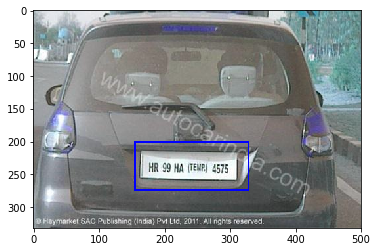

In [34]:
image = plt.imread('rectangle.png')
plt.imshow(image)
plt.show()

In [0]:
train_labels.to_csv('train_labels.csv', index=False)
test_labels.to_csv('test_labels.csv', index=False)